In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

tickers = {
    'Gold': 'GC=F',           # Золото фьючерс (близко к XAU/USD)
    'Silver': 'SI=F',         # Серебро 
    'DXY': 'DX-Y.NYB',        # DXY (работает лучше ^NYICDX)
    'SP500': '^GSPC',
    'VIX': '^VIX',
    'Oil': 'CL=F',
    'Treasury10Y': '^TNX',    # 10Y yield
    'Euro': 'EURUSD=X'        # EUR/USD для разнообразия
}

print("Загружаем ежедневные данные...")
data_daily = pd.DataFrame()
for name, ticker in tickers.items():
    print(f"  {name} ({ticker})")
    temp = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
    data_daily[name] = temp

data_daily = data_daily.dropna()
print(f"Готово! {len(data_daily)} дней данных с {data_daily.index[0].date()} по {data_daily.index[-1].date()}")
print(data_daily.tail())
data_daily.to_csv('data_daily_raw.csv')


Загружаем ежедневные данные...
  Gold (GC=F)
  Silver (SI=F)
  DXY (DX-Y.NYB)
  SP500 (^GSPC)
  VIX (^VIX)
  Oil (CL=F)
  Treasury10Y (^TNX)
  Euro (EURUSD=X)
Готово! 5257 дней данных с 2005-01-03 по 2026-01-27
                   Gold      Silver        DXY        SP500    VIX        Oil  \
Date                                                                            
2026-01-21  4831.799805   92.209999  98.760002  6875.620117  16.90  60.619999   
2026-01-22  4908.799805   95.975998  98.360001  6913.350098  15.64  59.360001   
2026-01-23  4976.200195  100.925003  97.599998  6915.609863  16.09  61.070000   
2026-01-26  5079.700195  115.080002  97.040001  6950.229980  16.15  60.630001   
2026-01-27  5079.899902  105.523003  96.220001  6978.600098  16.35  62.389999   

            Treasury10Y      Euro  
Date                               
2026-01-21        4.253  1.172787  
2026-01-22        4.249  1.167297  
2026-01-23        4.239  1.175461  
2026-01-26        4.213  1.185846  
2026-

PermissionError: [Errno 13] Permission denied: 'data_daily_raw.csv'

In [ ]:
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
print(df.columns)


MultiIndex([( 'Close', 'GC=F'),
            (  'High', 'GC=F'),
            (   'Low', 'GC=F'),
            (  'Open', 'GC=F'),
            ('Volume', 'GC=F')],
           names=['Price', 'Ticker'])


In [ ]:
df = data_daily.copy()

# Лаги золота (1, 5, 20 дней)
df['Gold_lag1'] = df['Gold'].shift(1)
df['Gold_lag5'] = df['Gold'].shift(5)
df['Gold_lag20'] = df['Gold'].shift(20)

# Returns (дневные изменения)
for col in ['Gold', 'SP500', 'Oil', 'DXY']:
    df[f'{col}_ret'] = df[col].pct_change()

# Rolling статистики (окно 20 дней ~ месяц)
df['Gold_rolling_mean_20'] = df['Gold'].rolling(20).mean()
df['VIX_rolling_mean_20'] = df['VIX'].rolling(20).mean()
df['SP500_vol_20'] = df['SP500_ret'].rolling(20).std()

# День недели, месяц (сезонность)
df['weekday'] = df.index.dayofweek
df['month'] = df.index.month

# Real rate proxy: Treasury10Y минус инфляция (CPI нет daily, используем proxy через bonds)
df['Real_rate_proxy'] = df['Treasury10Y'] - df['SP500_ret'].rolling(252).mean() * 100  # Годовая инфляция proxy

df = df.dropna()
print(f"После фич: {len(df)} наблюдений")
print(df.columns.tolist())
df.to_csv('data_daily_features.csv')


После фич: 5005 наблюдений
['Gold', 'Silver', 'DXY', 'SP500', 'VIX', 'Oil', 'Treasury10Y', 'Euro', 'Gold_lag1', 'Gold_lag5', 'Gold_lag20', 'Gold_ret', 'SP500_ret', 'Oil_ret', 'DXY_ret', 'Gold_rolling_mean_20', 'VIX_rolling_mean_20', 'SP500_vol_20', 'weekday', 'month', 'Real_rate_proxy']


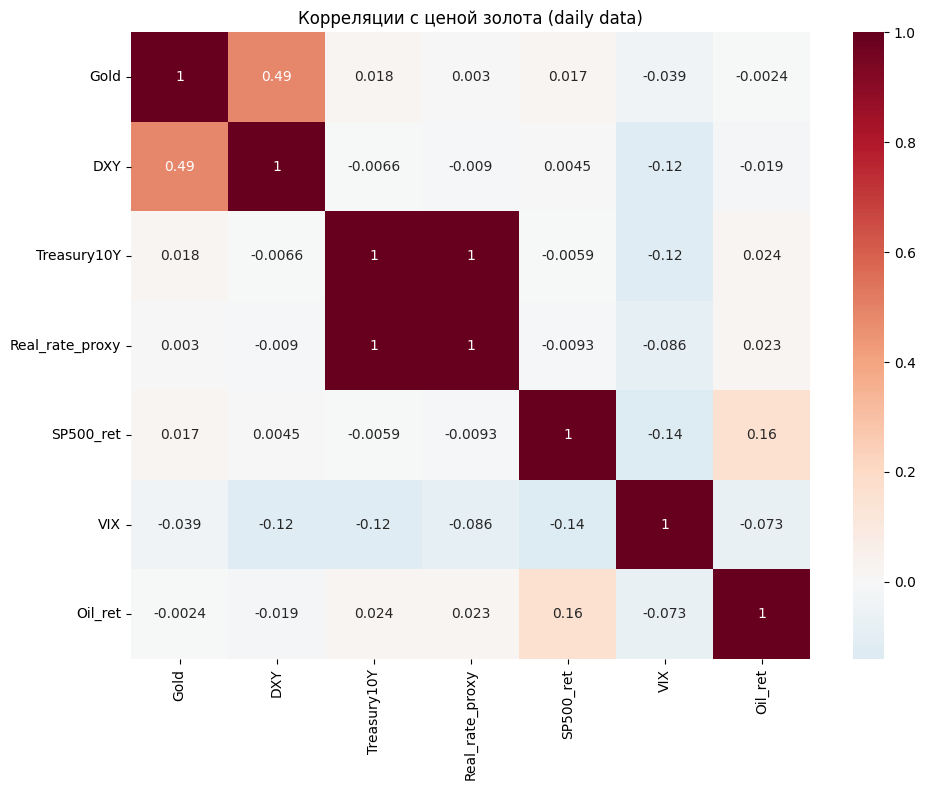

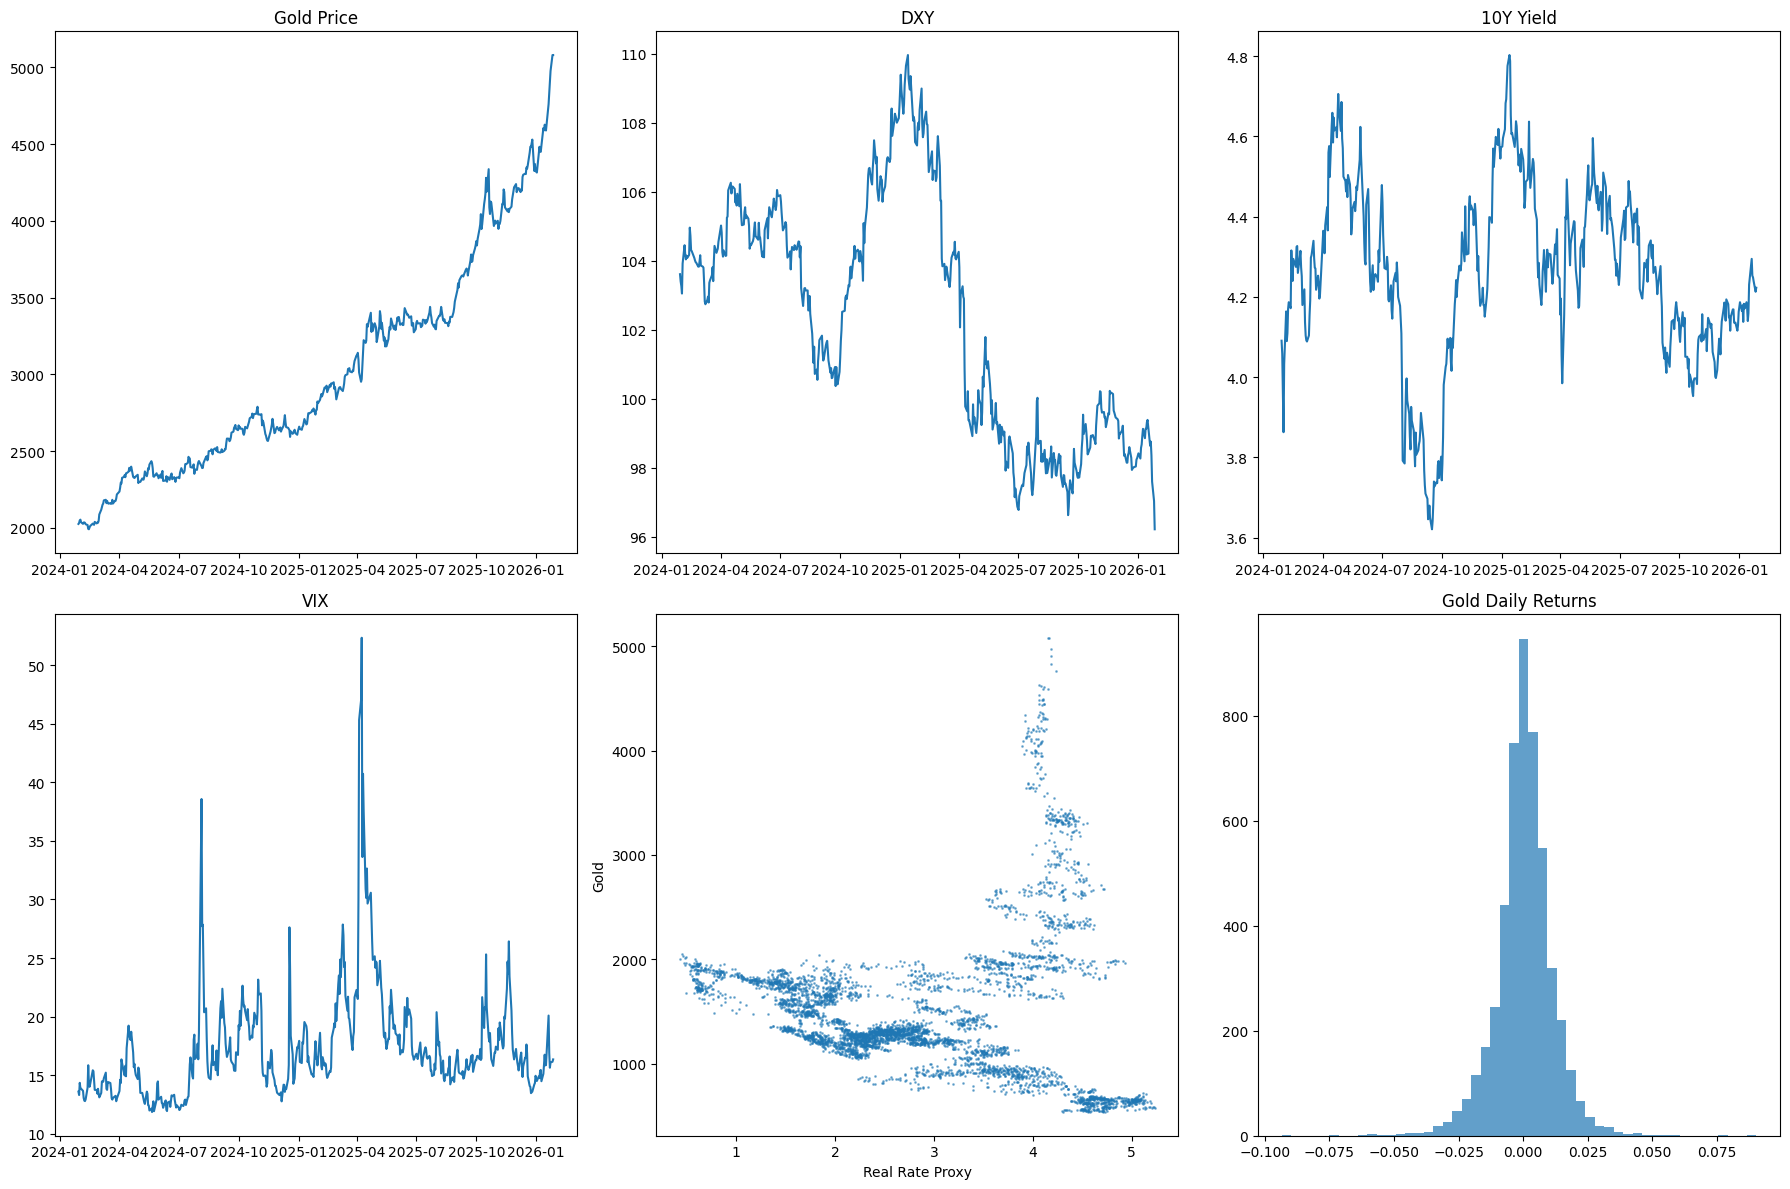

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Корреляции с золотом
corr_features = ['Gold', 'DXY', 'Treasury10Y', 'Real_rate_proxy', 'SP500_ret', 'VIX', 'Oil_ret']
corr_matrix = df[corr_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('Корреляции с ценой золота (daily data)')
plt.tight_layout()
plt.savefig('daily_correlations.png', dpi=300)
plt.show()

# Мультиграфик ключевых рядов
fig, axes = plt.subplots(2, 3, figsize=(18,12))
axes[0,0].plot(df.index[-500:], df['Gold'].tail(500))  # Последние 500 дней
axes[0,0].set_title('Gold Price')
axes[0,1].plot(df.index[-500:], df['DXY'].tail(500))
axes[0,1].set_title('DXY')
axes[0,2].plot(df.index[-500:], df['Treasury10Y'].tail(500))
axes[0,2].set_title('10Y Yield')
axes[1,0].plot(df.index[-500:], df['VIX'].tail(500))
axes[1,0].set_title('VIX')
axes[1,1].scatter(df['Real_rate_proxy'], df['Gold'], alpha=0.5, s=1)
axes[1,1].set_xlabel('Real Rate Proxy')
axes[1,1].set_ylabel('Gold')
axes[1,2].hist(df['Gold_ret'], bins=50, alpha=0.7)
axes[1,2].set_title('Gold Daily Returns')
plt.tight_layout()
plt.savefig('daily_eda.png', dpi=300)
plt.show()


In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Цель и признаки
X = df[feature_cols]
y = df[target_col]

# Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)

# XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_scaled, y)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Optional[float]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[str], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = loa

In [19]:
weights = {
    'ridge': 0.4,
    'xgb': 0.4,
    'arima': 0.2
}
total_weight = sum(weights.values())
rmse_ensemble = np.std(y) * 0.1  # грубая оценка


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[feature_cols]

scaler.fit(X)


import numpy as np
import pandas as pd

# ======================================================
# НАСТРОЙКИ
# ======================================================
target_col = 'Gold'
feature_cols = df.columns.drop(target_col).tolist()

np.random.seed(42)

n_forecast_days = 2500  # ~10 лет торговых дней
future_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=n_forecast_days,
    freq='B'
)

# ======================================================
# ГЕНЕРАЦИЯ FUTURE FEATURES (авторегрессия + тренды)
# ======================================================
future_X = pd.DataFrame(index=future_index, columns=feature_cols)

last_values = df[feature_cols].iloc[-1]

for col in feature_cols:
    if 'Gold_lag' in col:
        # Авторегрессия с затуханием
        future_X[col] = np.linspace(
            last_values[col],
            last_values[col] * 0.98,
            n_forecast_days
        )

    elif '_ret' in col:
        # Стохастика доходностей
        future_X[col] = np.random.normal(0, 0.01, n_forecast_days)

    elif col == 'Real_rate_proxy':
        # Плавное снижение ставок
        future_X[col] = np.linspace(
            last_values[col],
            last_values[col] - 0.5,
            n_forecast_days
        )

    else:
        # Общий тренд + шум
        trend = np.linspace(0, 0.1, n_forecast_days)
        noise = np.random.normal(0, 0.05, n_forecast_days)
        future_X[col] = last_values[col] * (1 + trend + noise)

# Защита от NaN
future_X = future_X.ffill()

# ======================================================
# СЦЕНАРИИ
# ======================================================
scenarios = {
    'Baseline': future_X.copy(),
    'Optimistic': future_X * 1.02,
    'Pessimistic': future_X * 0.98
}

# ======================================================
# ПРОГНОЗЫ
# ======================================================
forecast_daily = {}

for name, future_X_scen in scenarios.items():

    # Масштабирование (как при обучении Ridge)
    future_X_scaled = scaler.transform(future_X_scen)

    # Модели
    pred_ridge = ridge.predict(future_X_scaled)
    pred_xgb = xgb.predict(future_X_scaled)

    # ARIMA-like тренд (1% в год)
    pred_arima = df['Gold'].iloc[-1] * 1.01 ** (
        np.arange(n_forecast_days) / 252
    )

    # Ансамбль
    pred_ensemble = (
        weights['ridge'] * pred_ridge +
        weights['xgb'] * pred_xgb +
        weights['arima'] * pred_arima
    ) / total_weight

    sigma = rmse_ensemble

    forecast_daily[name] = pd.DataFrame(
        index=future_index,
        data={
            'Forecast': pred_ensemble,
            'CI80_low': pred_ensemble - 1.28 * sigma,
            'CI80_high': pred_ensemble + 1.28 * sigma,
            'CI95_low': pred_ensemble - 1.96 * sigma,
            'CI95_high': pred_ensemble + 1.96 * sigma
        }
    )

# ======================================================
# СОХРАНЕНИЕ
# ======================================================
pd.concat(forecast_daily, names=['Scenario']).to_csv('forecast_daily.csv')

print("forecast_daily.csv готов (ежедневный прогноз на 10 лет)")
print("\nBaseline — начало:")
print(forecast_daily['Baseline'].head())

print("\nBaseline — конец:")
print(forecast_daily['Baseline'].tail())


forecast_daily.csv готов (ежедневный прогноз на 10 лет)

Baseline — начало:
               Forecast     CI80_low    CI80_high     CI95_low    CI95_high
2026-01-28  4945.280019  4861.049963  5029.510075  4816.302746  5074.257292
2026-01-29  4933.874170  4849.644114  5018.104226  4804.896897  5062.851443
2026-01-30  4995.830422  4911.600366  5080.060478  4866.853149  5124.807695
2026-02-02  4993.815649  4909.585593  5078.045705  4864.838376  5122.792922
2026-02-03  4923.308976  4839.078920  5007.539032  4794.331703  5052.286250

Baseline — конец:
               Forecast     CI80_low    CI80_high     CI95_low    CI95_high
2035-08-22  5031.957169  4947.727112  5116.187225  4902.979895  5160.934442
2035-08-23  5031.465421  4947.235365  5115.695477  4902.488148  5160.442694
2035-08-24  5035.514033  4951.283977  5119.744089  4906.536759  5164.491306
2035-08-27  5036.376025  4952.145969  5120.606081  4907.398751  5165.353298
2035-08-28  5005.881577  4921.651520  5090.111633  4876.904303  5134.

In [4]:
access = '7e16fe38faf71392ad4c298e596ab8a7'

In [ ]:
start_date = '2000-01-01'
end_date = datetime.today().strftime("%Y-%m-%d")

In [23]:
correlation = df['Gold'].corr(df['DXY'])

print(f"Корреляция Пирсона: {correlation:.4f}")

Корреляция Пирсона: 0.4858


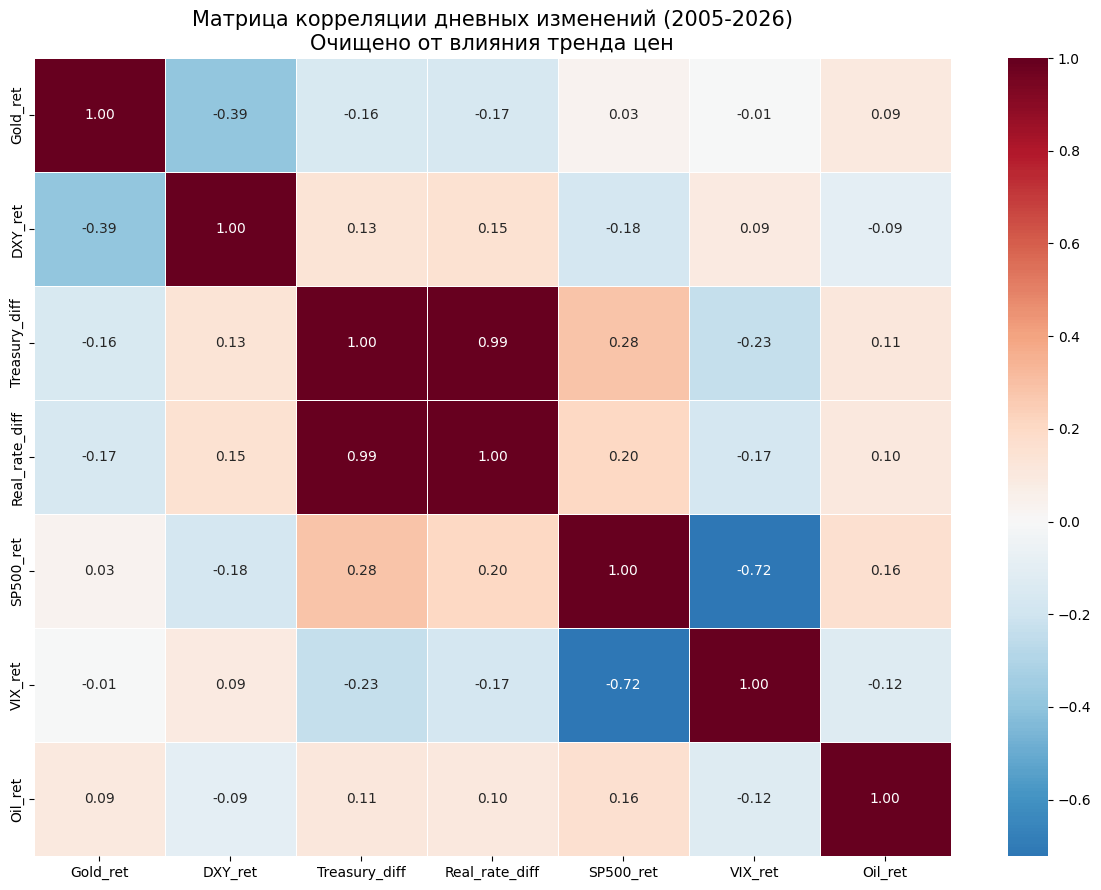

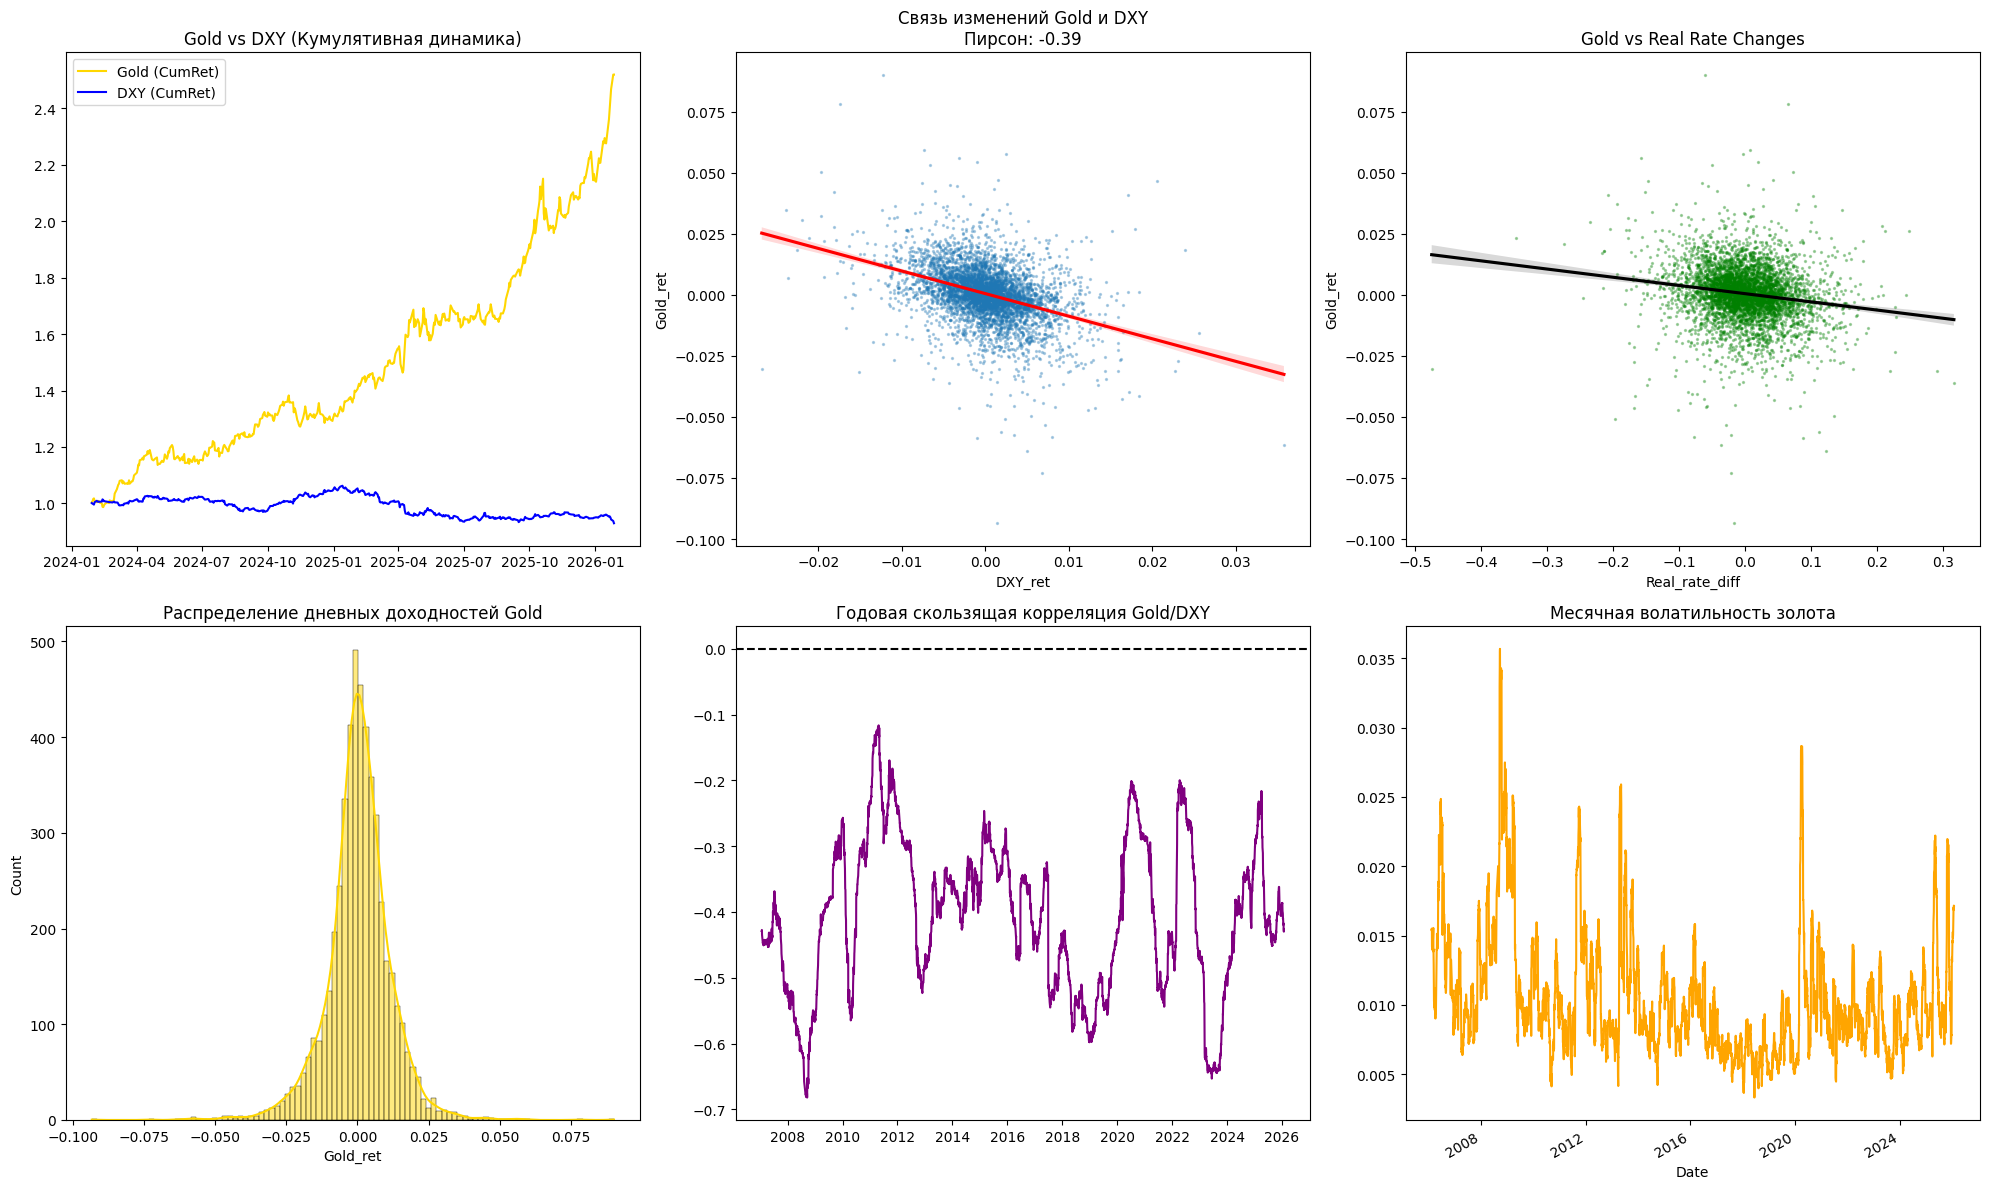

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ПОДГОТОВКА ДАННЫХ
# Создаем копию, чтобы не испортить исходный df
df_clean = df.copy()

# Для цен (Gold, DXY, VIX) используем процентное изменение (Returns)
# Для процентных ставок (Treasury, Real_rate) лучше использовать разность (Diff), так как они сами в %
df_clean['Gold_ret'] = df_clean['Gold'].pct_change()
df_clean['DXY_ret'] = df_clean['DXY'].pct_change()
df_clean['VIX_ret'] = df_clean['VIX'].pct_change()
df_clean['Treasury_diff'] = df_clean['Treasury10Y'].diff()
df_clean['Real_rate_diff'] = df_clean['Real_rate_proxy'].diff()

# Удаляем первую строку с NaN, возникшими из-за сдвига
df_clean = df_clean.dropna()

# 2. МАТРИЦА КОРРЕЛЯЦИИ (Чистые доходности)
# Выбираем только те признаки, которые отражают ДИНАМИКУ
corr_features = ['Gold_ret', 'DXY_ret', 'Treasury_diff', 'Real_rate_diff', 'SP500_ret', 'VIX_ret', 'Oil_ret']
corr_matrix = df_clean[corr_features].corr()

# Визуализация хитмапа
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции дневных изменений (2005-2026)\nОчищено от влияния тренда цен', fontsize=15)
plt.tight_layout()
plt.show()

# 3. МУЛЬТИГРАФИК ДЛЯ АНАЛИЗА (EDA)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# График 1: Золото vs DXY (Нормированные изменения для сравнения)
# Берем последние 500 дней для наглядности
tail_df = df_clean.tail(500)
axes[0,0].plot(tail_df.index, (1 + tail_df['Gold_ret']).cumprod(), label='Gold (CumRet)', color='gold')
axes[0,0].plot(tail_df.index, (1 + tail_df['DXY_ret']).cumprod(), label='DXY (CumRet)', color='blue')
axes[0,0].set_title('Gold vs DXY (Кумулятивная динамика)')
axes[0,0].legend()

# График 2: Scatter plot Gold vs DXY (Здесь вы увидите отрицательный наклон)
sns.regplot(x='DXY_ret', y='Gold_ret', data=df_clean, ax=axes[0,1], 
            scatter_kws={'alpha':0.3, 's':2}, line_kws={'color':'red'})
axes[0,1].set_title(f'Связь изменений Gold и DXY\nПирсон: {corr_matrix.loc["Gold_ret", "DXY_ret"]:.2f}')

# График 3: Scatter plot Gold vs Real Rates (Ключевой фундаментальный фактор)
sns.regplot(x='Real_rate_diff', y='Gold_ret', data=df_clean, ax=axes[0,2], 
            scatter_kws={'alpha':0.3, 's':2, 'color':'green'}, line_kws={'color':'black'})
axes[0,2].set_title('Gold vs Real Rate Changes')

# График 4: Распределение доходностей Золота (проверка на "тяжелые хвосты")
sns.histplot(df_clean['Gold_ret'], bins=100, kde=True, ax=axes[1,0], color='gold')
axes[1,0].set_title('Распределение дневных доходностей Gold')

# График 5: Скользящая корреляция (Rolling Correlation) - ПОКАЖЕТ ИЗМЕНЕНИЕ СВЯЗИ ВО ВРЕМЕНИ
rolling_corr = df_clean['Gold_ret'].rolling(252).corr(df_clean['DXY_ret'])
axes[1,1].plot(rolling_corr, color='purple')
axes[1,1].axhline(y=0, color='black', linestyle='--')
axes[1,1].set_title('Годовая скользящая корреляция Gold/DXY')

# График 6: Волатильность (Rolling Std)
df_clean['Gold_ret'].rolling(21).std().plot(ax=axes[1,2], color='orange')
axes[1,2].set_title('Месячная волатильность золота')

plt.tight_layout()
plt.show()